## Installing and Importing Packages, and Mounting Google Drive

In [1]:
# useful installations
!pip install sacremoses

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import re
import os
import sys
import math

import string
from collections import defaultdict

from google.colab import data_table

from sacremoses import MosesPunctNormalizer

In [3]:
# mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load Data

This involves reading the data from text files into lists, and converting the lists into a `pandas.DataFrame` for further processing.

When reading text files, we ensure that characters in the files are encoded as `utf-8` characters.

In [4]:
# define source and target languages
source_name = 'English'
target_name = 'Xitsonga'

source_code = 'eng'
target_code = 'tso'

In [5]:
# loading data
main_path = f'/content/drive/My Drive/Research/{source_code}-to-{target_code}'
source_path = f'{main_path}/{source_code}.txt'
target_path = f'{main_path}/{target_code}.txt'

with open(source_path, 'r', encoding='utf-8') as f:
  source = f.read().splitlines()

with open(target_path, 'r', encoding='utf-8') as f:
  target = f.read().splitlines()

In [6]:
# convert text files containing source and target segments to pandas.DataFrame
df = pd.DataFrame({source_name:source, target_name:target})
N = len(df)
print(f"The number of segment pairs in the parallel corpus BEFORE any preprocessing: {N}.")

The number of segment pairs in the parallel corpus BEFORE any preprocessing: 450000.


In [7]:
# visualise dataframe
data_table.DataTable(df, include_index=True, num_rows_per_page=20)

Output hidden; open in https://colab.research.google.com to view.

## Data Splitting

This involves splitting the parallel corpus into training/validation/testing corpora.

We have access to a global test corpus, we need to filter out any copies of the source segments in the global test corpus from the training and validation corpora.

### Splitting data into train/validation/test sets:

In [8]:
# shuffling segment pairs in the parallel corpus
seed = 2024
df = df.sample(frac=1, random_state=seed).reset_index(drop=True)

# splitting parallel corpus
df_test = df.sample(n=3000, random_state=seed)
df_train = df.drop(df_test.index, axis=0, inplace=False)
df_val = df_train.sample(frac=0.2, random_state=seed)
df_train.drop(df_val.index, axis=0, inplace=True)

# resetting index in dataframe after dropping segment pairs
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

print(f"Number of segment pairs in training set: {len(df_train)}")
print(f"Number of segment pairs in validation set: {len(df_val)}")
print(f"Number of segment pairs in test set: {len(df_test)}")

Number of segment pairs in training set: 357600
Number of segment pairs in validation set: 89400
Number of segment pairs in test set: 3000


### Filtering out segment pairs from test set and global test set:

In [9]:
# filtering segment pairs from training set using test corpus
index = df_train[df_train[source_name].isin(df_test)].index
if len(index) > 0:
  df_train.drop(index, axis=0, inplace=True)
  print(f"Segments are being removed from the corpus...")
print(f"The number of segment pairs left in the training corpus: {len(df_train)} \n")

# filtering segment pairs from validation set using test corpus
index = df_val[df_val[source_name].isin(df_test)].index
if len(index) > 0:
  df_val.drop(index, axis=0, inplace=True)
  print(f"Segments are being removed from the corpus...")
print(f"The number of segments pairs left in the validation corpus: {len(df_val)}")

# resetting index in dataframe after dropping segment pairs
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)

The number of segment pairs left in the training corpus: 357600 

The number of segments pairs left in the validation corpus: 89400


In [10]:
gtest_path = f'{main_path}/Autshumato-Evaluation-Set/Autshumato.EvaluationSet.English.Translator1.txt'
with open(gtest_path, 'r', encoding='utf-8') as f:
  gtest = f.read().splitlines()

# filtering segment pairs from training set using global test corpus 1
index = df_train[df_train[source_name].isin(gtest)].index
if len(index) > 0:
  df_train.drop(index, axis=0, inplace=True)
  print(f"Segments are being removed from the corpus...")
print(f"The number of segment pairs left in the training corpus: {len(df_train)} \n")

# filtering segment pairs from validation set using global test corpus 1
index = df_val[df_val[source_name].isin(gtest)].index
if len(index) > 0:
  df_val.drop(index, axis=0, inplace=True)
  print(f"Segments are being removed from the corpus...")
print(f"The number of segments pairs left in the validation corpus: {len(df_val)}")

# resetting index in dataframe after dropping segment pairs
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)

Segments are being removed from the corpus...
The number of segment pairs left in the training corpus: 352793 

Segments are being removed from the corpus...
The number of segments pairs left in the validation corpus: 88197


## Text Normalization

This involves improving the consistency of text within a language, and between source and target segments in a segment pair.

The following steps for text normalization are deployed in training and validation corpora.

### Checking for invalid `utf-8` characters:

In [11]:
# function to check for invalid utf-8 characters in a segment
def check_invalid_utf8(segment):
  """
  This function checks if a segment contains invalid UTF-8 characters.

  Args:
    segment (str): The segment to be processed.

  Return:
    True if the segment contains an invalid UTF-8 character, False otherwise.
  """

  try:
    segment.encode('utf-8').decode('utf-8')
    return False
  except UnicodeDecodeError:
    return True

In [12]:
# are there any invalid utf-8 characters in the training corpus?
invalid_utf8_source = []
invalid_utf8_target = []

for i in range(len(df_train)):
  if check_invalid_utf8(df_train.iloc[i,0]) == True:
    invalid_utf8_source.append(i)

  if check_invalid_utf8(df_train.iloc[i,1]) == True:
    invalid_utf8_target.append(i)

print("Training Corpus:")
print(f"The number of segments on the {source_name} side with invalid UTF-8 characters: {len(invalid_utf8_source)}.")
print(f"The number of segments on the {target_name} side with invalid UTF-8 characters: {len(invalid_utf8_target)}.")

# are there any invalid utf-8 characters in the validation corpus?
invalid_utf8_source = []
invalid_utf8_target = []

for i in range(len(df_val)):
  if check_invalid_utf8(df_val.iloc[i,0]) == True:
    invalid_utf8_source.append(i)

  if check_invalid_utf8(df_val.iloc[i,1]) == True:
    invalid_utf8_target.append(i)

print("\nValidation Corpus:")
print(f"The number of segments on the {source_name} side with invalid UTF-8 characters: {len(invalid_utf8_source)}.")
print(f"The number of segments on the {target_name} side with invalid UTF-8 characters: {len(invalid_utf8_target)}.")

Training Corpus:
The number of segments on the English side with invalid UTF-8 characters: 0.
The number of segments on the Xitsonga side with invalid UTF-8 characters: 0.

Validation Corpus:
The number of segments on the English side with invalid UTF-8 characters: 0.
The number of segments on the Xitsonga side with invalid UTF-8 characters: 0.


### Removing non-printable characters:

In [13]:
# are there any non-printable characters in the training corpus?
non_print_source = []
non_print_target = []

for i in range(len(df_train)):
  if df_train.iloc[i,0].isprintable() == False:
    non_print_source.append(i)

  if df_train.iloc[i,1].isprintable() == False:
    non_print_target.append(i)

print("Training Corpus:")
print(f"The number of segments on the {source_name} side with non-printable characters: {len(non_print_source)}.")
print(f"The number of segments on the {target_name} side with non-printable characters: {len(non_print_target)}.")

Training Corpus:
The number of segments on the English side with non-printable characters: 167.
The number of segments on the Xitsonga side with non-printable characters: 162.


In [14]:
# visualise source segments with non-printable characters
df_train.iloc[non_print_source, 0].tolist()

['\uf0a7 Reforming the planning system to resolve fragmented responsibility for planning in national government , poorly coordinated intergovernmental planning , disconnects across municipal boundaries and the limitations of integrated development plans . ',
 '\uf0a7 Broaden social cohesion and unity while redressing the inequities of the past . ',
 '\uf0a7 Improving economic policy coordination and implementation ',
 '\uf0a7 Uniting all South Africans around a common programme to achieve prosperity and equity . ',
 '\uf0a7 A more efficient and competitive infrastructure . ',
 '\uf0a7 The country should continuously seek to improve the efficacy of black economic empowerment models . ',
 '\uf0a7 Broaden ownership of assets to historically disadvantaged groups . ',
 '\uf0a7 A hybrid system for appointing heads of departments should be introduced , incorporating both political and administrative elements . ',
 '\uf0a7 Focused partnerships with the private sector to bridge the housing gap 

In [15]:
# visualise target segments with non-printable characters
df_train.iloc[non_print_target, 1].tolist()

['\uf0a7 Ku hundzuluxa sisiteme ya makunguhatelo ku ololoxa vutihlamuleri lebyi hambanisiweke bya makunguhatelo eka mfumo wa rixaka , makunguhatelo ya le xikarhi ka mifumo lama hlanganisiweke hi xiyimo xa le hansi , ku tsemeka eka mindzilakana ya timasipala na swirhalanganyi swa makungu lama pfanganyisiweke ya nhluvukiso . ',
 "\uf0a7 Anamisa nkhomano wa vanhu na vun'we hi ku tirhisiwa ka titalenta na swipfuno swa Maafrika-Dzonga hinkwavo , loko ku ri karhi ku tekiwa magoza yo tiya ya ku lulamisa ku nga ringani loku veke kona nkarhi lowu nga hundza . ",
 '\uf0a7 Ku antswisa vuhlanganisi na masimekelo ya tipholisi ta ikhonomi ',
 "\uf0a7 Ku vumba vun'we bya Maafrika-Dzonga eka minongonoko yo fana ku fikelela ku humelela na ndzingano . ",
 '\uf0a7 Switirhisiwankulu leswi tirhaka hi ndlela leyi vuyerisaka na ku va na leswi phikizanaka swinene . ',
 '\uf0a7 Tiko ri fanele ku ya emahlweni ri ri karhi ri lava ku antswisa vuswikoti byo humesa mbuyelo wa timodlolo to havaxerisa matimba eka Van

In [16]:
# function to remove non-printable characters from the segment
def remove_non_printable_chars(segment):
  """
  This function removes non-printable characters from a segment.

  Args:
    segment (str): The segment to be processed.

  Returns:
    The segment without non-printable characters.
  """

  return "".join([char for char in segment if char.isprintable()])

In [17]:
# remove non-printable characters from the training corpus
for i in non_print_source:
  df_train.iloc[i,0] = remove_non_printable_chars(df_train.iloc[i,0])

for i in non_print_target:
  df_train.iloc[i,1] = remove_non_printable_chars(df_train.iloc[i,1])


In [18]:
# are there any non-printable characters in the validation corpus?
non_print_source = []
non_print_target = []

for i in range(len(df_val)):
  if df_val.iloc[i,0].isprintable() == False:
    non_print_source.append(i)

  if df_val.iloc[i,1].isprintable() == False:
    non_print_target.append(i)

print("\nValidation Corpus:")
print(f"The number of segments on the {source_name} side with non-printable characters: {len(non_print_source)}.")
print(f"The number of segments on the {target_name} side with non-printable characters: {len(non_print_target)}.")


Validation Corpus:
The number of segments on the English side with non-printable characters: 40.
The number of segments on the Xitsonga side with non-printable characters: 39.


In [19]:
# visualise source segments with non-printable characters
df_val.iloc[non_print_source, 0].tolist()

['\uf0a7 Improving the quality of education , skills development and innovation ',
 '\uf0a7 Establishing new norms and a national spatial framework . ',
 '\uf0a7 Promote mixed housing strategies and more compact urban development to help people access public spaces and facilities ',
 '\uf0a7 Public employment should expand , with a focus on youth and women . ',
 '\uf0a7 Work together with others in the community to advance development ',
 '\uf0a7 Entrench a social security system covering all working people , with social protection for the poor and other groups in need , such as children and people with disabilities . ',
 '\uf0a7 Ensure that all people live safely ',
 '\uf0a7 Building community participation . ',
 '\uf0a7 Increase the share of national income of the bottom 40 percent from 6 percent to 10 percent . ',
 '\uf0a7 Constructing infrastructure to import liquefied natural gas and increasing exploration to find domestic gas feedstock ( including investigating shale and coal bed

In [20]:
# visualise target segments with non-printable characters
df_val.iloc[non_print_target, 1].tolist()

['\uf0a7 Ku antswisa xiyimo xa dyondzo , swikili swa nhluvukiso na vutumbuluxi ',
 '\uf0a7 Ku tumbuluxa mitolovelo yintshwa na rimba ra tindhawu ra rixaka . ',
 '\uf0a7 Kondletela maqhinga ya tindlu to hlangahlangana na nhluvukiso wa matikoxidoroba lowu nga khomana swinene ku pfuna vanhu ku fikelela tindhawu ta vaaki na swivevukisi ',
 '\uf0a7 Mitirho ya vaaki yi fanele ku ndlandlamuka , yi ri na nkongomisa eka vantshwa na vavasati . ',
 "\uf0a7 Tirhisana na van'wana emigangeni ku yisa emahlweni nhluvukiso ",
 "\uf0a7 Tumbuluxa hi matimba sisiteme ya nsirhelelo wa vanhu leyi angarhelaka vanhu hinkwavo lava tirhaka , leyi nga na nsirhelelo wa vanhu lava nga swela na mitlawa yin'wana leyi yi pfumalaka , yo tanihi vana na vanhu lava nga na vutsoniwa . ",
 '\uf0a7 Tiyisisa leswaku vanhu hinkwavo va hanya va hlayisekile ',
 '\uf0a7 Ku aka vutekaxiave bya vaakindhawu . ',
 '\uf0a7 Engetela nkavelo wa mbuyelo wa rixaka wa 40 wa tiphesente ta le hansi ku suka eka 6 wa tiphesente ku fika eka 10

In [21]:
# remove non-printable characters from the validation corpus
for i in non_print_source:
  df_val.iloc[i,0] = remove_non_printable_chars(df_val.iloc[i,0])

for i in non_print_target:
  df_val.iloc[i,1] = remove_non_printable_chars(df_val.iloc[i,1])

### Normalising punctuation use:


In [22]:
# check for em dash
for i in range(len(df_train)):
  if "―" in df_train.iloc[i,0]:
    print("present on source side!")

  if "―" in df_train.iloc[i,1]:
    print("present on target side!")

In [23]:
# a function that does the following: if a hyphen is being used as a dash,
# then there should be a space BEFORE and AFTER the hyphen.
def hyphen_as_dash(segment):
  """
  This function determines whether a hyphen is being used as a dash. If yes,
  then it ensures that there is a whitespace before and after the hyphen.

  Args:
    segment (str): segment to be processed.

  Returns:
    The segment with hyphens as dashes with whitespace before and after the hyphen.
  """
  segment = " " + segment + " "
  indices = [index for (index, token) in enumerate(segment) if token == "-"]
  for i in indices:
    if segment[i+1] == " ":
      segment = segment[:i] + " -" + segment[i+1:]
  return segment[1:-1]

In [24]:
# ensure that there is a whitespace before and after hyphens that are being used as dashes.
# any extra whitespace will be removed by `MosesPunctNormalizer()`
for i in range(len(df_train)):
  if "-" in df_train.iloc[i,0]:
    df_train.iloc[i,0] = hyphen_as_dash(df_train.iloc[i,0])
  if "-" in df_train.iloc[i,1]:
    df_train.iloc[i,1] = hyphen_as_dash(df_train.iloc[i,1])

for i in range(len(df_val)):
  if "-" in df_val.iloc[i,0]:
    df_val.iloc[i,0] = hyphen_as_dash(df_val.iloc[i,0])
  if "-" in df_val.iloc[i,1]:
    df_val.iloc[i,1] = hyphen_as_dash(df_val.iloc[i,1])

In [25]:
# creating an instance of the sacremoses punctuation normalizer class
moses_punct_norm = MosesPunctNormalizer(
    lang="en",
    penn=True,                      # Normalize Penn Treebank style quotations.
    norm_quote_commas=True,         # Normalize quotations and commas
    norm_numbers=True,              # Normalize numbers
    pre_replace_unicode_punct=True, # Replace all punctuation with unicode punctuation
    post_remove_control_chars=True) # Remove all control characters

In [26]:
# normalising punctuation in training corpus
for i in range(len(df_train)):
  df_train.iloc[i,0] = moses_punct_norm.normalize(df_train.iloc[i,0])
  df_train.iloc[i,1] = moses_punct_norm.normalize(df_train.iloc[i,1])

# normalising punctuation in validation corpus
for i in range(len(df_val)):
  df_val.iloc[i,0] = moses_punct_norm.normalize(df_val.iloc[i,0])
  df_val.iloc[i,1] = moses_punct_norm.normalize(df_val.iloc[i,1])

### Normalising letter casing:

In [27]:
# which segments have words in all caps in the training corpus?
source_caps = []
target_caps = []

for i in range(len(df_train)):
  for s_word in df_train.iloc[i,0].split():
    if len(s_word) > 1 and s_word.isupper() == True:
      source_caps.append(i)

  for t_word in df_train.iloc[i,1].split():
    if len(t_word) > 1 and t_word.isupper() == True:
      target_caps.append(i)

source_caps = list(set(source_caps))
target_caps = list(set(target_caps))

In [28]:
# visualise source side
data_table.DataTable(df_train.iloc[source_caps], include_index=True, num_rows_per_page=20)

Output hidden; open in https://colab.research.google.com to view.

In [29]:
# visualise target side
data_table.DataTable(df_train.iloc[target_caps], include_index=True, num_rows_per_page=20)

Output hidden; open in https://colab.research.google.com to view.

In [30]:
# if all upper caps on source side, then source and target sides must be all lower caps, and
# if all upper caps on target side, then source and target sides must be all lower caps.
caps = list(set(source_caps + target_caps))

for i in caps:
  if df_train.iloc[i,0].isupper() == True:
    df_train.iloc[i,0] = df_train.iloc[i,0].lower()
    df_train.iloc[i,1] = df_train.iloc[i,1].lower()

  if df_train.iloc[i,1].isupper() == True:
    df_train.iloc[i,0] = df_train.iloc[i,0].lower()
    df_train.iloc[i,1] = df_train.iloc[i,1].lower()

In [31]:
# visualise dataframe
data_table.DataTable(df_train.iloc[caps], include_index=True, num_rows_per_page=20)

Output hidden; open in https://colab.research.google.com to view.

In [32]:
# which segments have words in all caps in the validation corpus?
source_caps = []
target_caps = []

for i in range(len(df_val)):
  for s_word in df_val.iloc[i,0].split():
    if len(s_word) > 1 and s_word.isupper() == True:
      source_caps.append(i)

  for t_word in df_val.iloc[i,1].split():
    if len(t_word) > 1 and t_word.isupper() == True:
      target_caps.append(i)

source_caps = list(set(source_caps))
target_caps = list(set(target_caps))

In [33]:
# if all upper caps on source side, then source and target sides must be all lower caps, and
# if all upper caps on target side, then source and target sides must be all lower caps.
caps = list(set(source_caps + target_caps))

for i in caps:
  if df_val.iloc[i,0].isupper() == True:
    df_val.iloc[i,0] = df_val.iloc[i,0].lower()
    df_val.iloc[i,1] = df_val.iloc[i,1].lower()

  if df_val.iloc[i,1].isupper() == True:
    df_val.iloc[i,0] = df_val.iloc[i,0].lower()
    df_val.iloc[i,1] = df_val.iloc[i,1].lower()

### Ensuring that there is a space between words and punctuation marks:



In [34]:
# function to ensure that there is a whitespace before and after punctuation marks
punc = string.punctuation.replace("-", "") # we exclude hyphen because it has already been dealt with
punc = punc.replace("'", "")

# add whitespace before punctuation mark
def add_whitespace_before_punct(segment):
  """
  This function ensures that there is a whitespace before each punctuation mark.

  Args:
    segment (str): The segment to be processed.

  Returns:
    The segment with whitespace before punctuation marks.

  """
  punc_positions = []
  for i, symbol in enumerate(segment):
    if symbol in punc:
      punc_positions.append(i)

  for i in range(len(punc_positions)):
    if segment[punc_positions[i]-1] != " ":
      segment = segment[0:punc_positions[i]] + " " + segment[punc_positions[i]:]
      punc_positions[i+1: ] = [pos+1 for pos in punc_positions[i+1: ]]

  return segment

# add whitespace after punctuation mark
def add_whitespace_after_punct(segment):
  """
  This function ensures that there is a whitespace after each punctuation mark,
  excluding punctuation mark at the end of a segment.

  Args:
    segment (str): The segment to be processed.

  Returns:
    The segment with whitespace after punctuation marks.

  """
  punc_positions = []
  for i, symbol in enumerate(segment):
    if symbol in punc:
      punc_positions.append(i)

  if punc_positions != []:
    if punc_positions[-1] == len(segment)-1:
      punc_positions = punc_positions[:-1]

    for i in range(len(punc_positions)):
      if segment[punc_positions[i]+1] != " ":
        segment = segment[0:punc_positions[i]+1] + " " + segment[punc_positions[i]+1:]
        punc_positions[i+1: ] = [pos+1 for pos in punc_positions[i+1: ]]

  return segment

In [35]:
# adding whitespaces before and after punctuation marks for the entire training corpus
for i in range(len(df_train)):
  df_train.iloc[i,0] = add_whitespace_after_punct(add_whitespace_before_punct(df_train.iloc[i,0])).strip()
  df_train.iloc[i,1] = add_whitespace_after_punct(add_whitespace_before_punct(df_train.iloc[i,1])).strip()

# adding whitespaces before and after punctuation marks for the entire validation corpus
for i in range(len(df_val)):
  df_val.iloc[i,0] = add_whitespace_after_punct(add_whitespace_before_punct(df_val.iloc[i,0])).strip()
  df_val.iloc[i,1] = add_whitespace_after_punct(add_whitespace_before_punct(df_val.iloc[i,1])).strip()

In [36]:
# visualising dataframe
data_table.DataTable(df_train.head(10), include_index=True, num_rows_per_page=10)

,English,Xitsonga
0,Visa,Vhisa
1,After 14 days report to the clerk of the court...,endzhaku ka masiku ya 14 yana eka mabalana wa ...
2,Registration also applies to all existing lawf...,Ntsariso wa tirha na le ka milawu leyi nga kon...
3,if the injury takes long to heal,loko ku vaviseka ku teka nkarhi ku hola
4,This will replace the current jumble of illega...,Leswi swi ta siva mpfilumpfilu wa mifungho ley...
5,For more details refer to the SARS website www...,Ku kuma vuxokoxoko yana eka website ya SARS ya...
6,"No proposals are made in this respect , however .","Hambiswiritano , ku hava minsusumeto leyi nyik..."
7,Obtaining the information and providing feedba...,Ku kuma mahungu na ku nyika mbuyelo i mhaka ya...
8,Tax deduction directive pension form B,Fomo ya B ya ku lerisa nsuso wa xibalo
9,"If a child is accompanying you , you must bring :","Loko n'wana a famba na wena , u fanele ku ta na :"


## Filtering out Segment Pairs

This involves filtering out segment pairs that are potentially misaligned.

### Removing empty lines:



In [37]:
# removing empty lines in training corpus
empty_lines = []
for i in range(len(df_train)):
  if df_train.iloc[i,0] == '' or df_train.iloc[i,1] == '':
    empty_lines.append(i)

df_train.drop(empty_lines, axis=0, inplace=True)
print(f"The number of segment pairs left in training corpus: {len(df_train)}")

# removing empty lines in validation corpus
empty_lines = []
for i in range(len(df_val)):
  if df_val.iloc[i,0] == '' or df_val.iloc[i,1] == '':
    empty_lines.append(i)

df_val.drop(empty_lines, axis=0, inplace=True)
print(f"The number of segment pairs left in validation corpus: {len(df_val)}")

The number of segment pairs left in training corpus: 352793
The number of segment pairs left in validation corpus: 88197


In [38]:
# resetting index in dataframes after dropping segment pairs
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)

### Removing duplicates:

In [39]:
# remove duplicate source-target pairs
df_train.drop_duplicates(inplace=True)
print(f"The number of segment pairs left in training corpus: {len(df_train)}")

df_val.drop_duplicates(inplace=True)
print(f"The number of segment pairs left in validation corpus: {len(df_val)}")

The number of segment pairs left in training corpus: 171758
The number of segment pairs left in validation corpus: 47445


In [40]:
# remove segments that are identical on the source and target side
identical_pairs = df_train[df_train[source_name] == df_train[target_name]].index
df_train.drop(identical_pairs, inplace=True)
print(f"The number of segment pairs left in training corpus: {len(df_train)}")

identical_pairs = df_val[df_val[source_name] == df_val[target_name]].index
df_val.drop(identical_pairs, inplace=True)
print(f"The number of segment pairs left in validation corpus: {len(df_val)}")

The number of segment pairs left in training corpus: 170984
The number of segment pairs left in validation corpus: 47163


In [41]:
# remove repeating segment pairs where the same source segment is aligned with multiple different target segments
df_train.drop_duplicates(subset=source_name, inplace=True)
print(f"The number of segment pairs left in training corpus: {len(df_train)}")

df_val.drop_duplicates(subset=source_name, inplace=True)
print(f"The number of segment pairs left in validation corpus: {len(df_val)}")

The number of segment pairs left in training corpus: 156924
The number of segment pairs left in validation corpus: 45354


In [42]:
# remove repeating segment pairs where the same target segment is aligned with multiple different source segments
df_train.drop_duplicates(subset=target_name, inplace=True)
print(f"The number of segment pairs left in training corpus: {len(df_train)}")

df_val.drop_duplicates(subset=target_name, inplace=True)
print(f"The number of segment pairs left in validation corpus: {len(df_val)}")

The number of segment pairs left in training corpus: 152451
The number of segment pairs left in validation corpus: 44439


In [43]:
# resetting index in dataframes after dropping segment pairs
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)

### Removing outlier segment pairs w.r.t length of segment:

In [44]:
# create a new dataframe: length of sentences on each side of the training corpus
df_train_sent_len = pd.DataFrame({source_name: df_train[source_name].str.split().apply(len), target_name:df_train[target_name].str.split().apply(len)})
print("Summary for Training Corpus:")
print(df_train_sent_len.describe())

# create a new dataframe: length of sentences on each side of the validation corpus
df_val_sent_len = pd.DataFrame({source_name: df_val[source_name].str.split().apply(len), target_name:df_val[target_name].str.split().apply(len)})
print("\nSummary for Validation Corpus:")
print(df_val_sent_len.describe())

Summary for Training Corpus:
             English       Xitsonga
count  152451.000000  152451.000000
mean       10.494684      12.372808
std         7.925734       9.903940
min         1.000000       1.000000
25%         6.000000       7.000000
50%         9.000000      10.000000
75%        12.000000      15.000000
max       153.000000     235.000000

Summary for Validation Corpus:
            English      Xitsonga
count  44439.000000  44439.000000
mean      10.244065     12.106596
std        8.035730      9.955642
min        1.000000      1.000000
25%        5.000000      6.000000
50%        9.000000     10.000000
75%       12.000000     15.000000
max      104.000000    172.000000


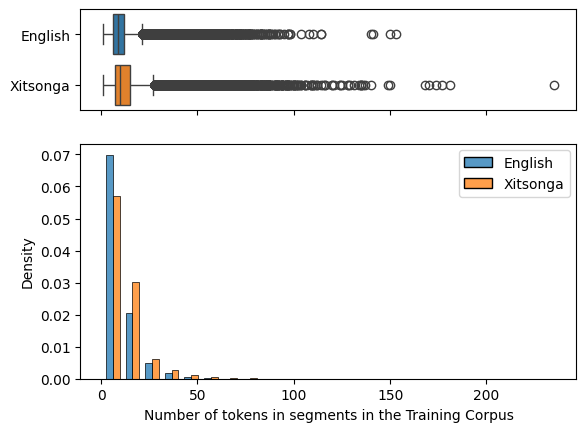

In [45]:
# visualise length of segments in parallel corpus
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.3, .7)})
sns.boxplot(df_train_sent_len.iloc[:, [0,1]], orient="h", ax=ax_box)
sns.histplot(df_train_sent_len.iloc[:, [0,1]],
             binwidth=10,
             stat='density',
             multiple='dodge',
             shrink=0.7,
             legend=True,
             common_norm=False,
             ax=ax_hist)

# add labels to plots
ax_hist.set_xlabel("Number of tokens in segments in the Training Corpus")
ax_hist.set_ylabel("Density")

# display plot
plt.show()

In [46]:
# outliers on the source side of the training set
q1 = df_train_sent_len.iloc[:, 0].quantile(0.25)
q3 = df_train_sent_len.iloc[:, 0].quantile(0.75)
iqr =  q3 - q1
lower_source_outliers = q1 - (3 * iqr)
upper_source_outliers = q3 + (3 * iqr)
print(f"The outliers upper and lower bounds for the source side of training corpus: ({lower_source_outliers}, {upper_source_outliers})")

# outliers of the target side
q1 = df_train_sent_len.iloc[:, 1].quantile(0.25)
q3 = df_train_sent_len.iloc[:, 1].quantile(0.75)
iqr =  q3 - q1
lower_target_outliers = q1 - (3 * iqr)
upper_target_outliers = q3 + (3 * iqr)
print(f"The outliers upper and lower bounds for the target side of training corpus: ({lower_target_outliers}, {upper_target_outliers})")

The outliers upper and lower bounds for the source side of training corpus: (-12.0, 30.0)
The outliers upper and lower bounds for the target side of training corpus: (-17.0, 39.0)


In [47]:
data_table.DataTable(df_train[df_train_sent_len[source_name] > 40], include_index=True, num_rows_per_page=20)



,English,Xitsonga
482,It also allows a person to take water for smal...,Wu pfumelela munhu ku tirhisa mati matsongo ek...
493,If people want to park or place any object or ...,"Loko vanhu va lava ku paka , kumbe ku vekela n..."
649,That before a consumer's water is disconnected...,Leswaku ku nga se va na ku tsemiwa ka mphakelo...
698,Financial or economic abuse or exploitation : ...,Ku xanisiwa hi swa timali kumbe ikhonomi kumbe...
794,"We are confident that , informed by their abho...","Hi na ntshembho leswaku , kuya hi xihlawuhlawu..."
...,...,...
152140,The Transnet projects form part of the state-o...,Tiphurojeke ta Transnet i xiphemu xa Maendlelo...
152206,"Dr Charles Kayuunga , who led the Zambian dele...","Dok Charles Kayuunga , loyi a rhangele vurhumi..."
152217,Speaking at the launch of the FET Expansion an...,Loko a vulavula hi nkarhi wa ku simekiwa ka Nk...
152281,The Strategy 2 also seeks to ensure sustainabl...,Xitirateji xa vumbirhi na xona xi lava ku tiyi...


In [48]:
data_table.DataTable(df_train[df_train_sent_len[target_name] > 50], include_index=True, num_rows_per_page=20)

,English,Xitsonga
284,A person who becomes liable for the payment of...,Munhu loyi a bohekaku ku hakela muthelo wa xin...
318,Complete the CM44 form - Articles of associati...,Tatani fomo ya CM44 - Articles of association ...
455,The costs of this transition will not fall eve...,Tihakelo ta ku cinca a ti nga ringaneli ka van...
482,It also allows a person to take water for smal...,Wu pfumelela munhu ku tirhisa mati matsongo ek...
493,If people want to park or place any object or ...,"Loko vanhu va lava ku paka , kumbe ku vekela n..."
...,...,...
152169,The planning required for the first year a com...,Nkunguhato lowu lavekaka eka lembe ro sungula ...
152206,"Dr Charles Kayuunga , who led the Zambian dele...","Dok Charles Kayuunga , loyi a rhangele vurhumi..."
152217,Speaking at the launch of the FET Expansion an...,Loko a vulavula hi nkarhi wa ku simekiwa ka Nk...
152281,The Strategy 2 also seeks to ensure sustainabl...,Xitirateji xa vumbirhi na xona xi lava ku tiyi...


In [49]:
# outliers on the source side of the validation set
q1 = df_val_sent_len.iloc[:, 0].quantile(0.25)
q3 = df_val_sent_len.iloc[:, 0].quantile(0.75)
iqr =  q3 - q1
lower_source_outliers = q1 - (3 * iqr)
upper_source_outliers = q3 + (3 * iqr)
print(f"The outliers upper and lower bounds for the source side of the validation corpus: ({lower_source_outliers}, {upper_source_outliers})")

# outliers of the target side
q1 = df_val_sent_len.iloc[:, 1].quantile(0.25)
q3 = df_val_sent_len.iloc[:, 1].quantile(0.75)
iqr =  q3 - q1
lower_target_outliers = q1 - (3 * iqr)
upper_target_outliers = q3 + (3 * iqr)
print(f"The outliers upper and lower bounds for the target side of the validation corpus: ({lower_target_outliers}, {upper_target_outliers})")

The outliers upper and lower bounds for the source side of the validation corpus: (-16.0, 33.0)
The outliers upper and lower bounds for the target side of the validation corpus: (-21.0, 42.0)


In [50]:
# dropping segment pairs in training corpus
source_max_length = 40
target_max_length = 50

source_min_length = 1
target_min_length = 1

drop_index = []

for i in range(len(df_train_sent_len)):
  if df_train_sent_len.iloc[i,0] < source_min_length:
    drop_index.append(i)
  if df_train_sent_len.iloc[i,0] > source_max_length:
    drop_index.append(i)

  if df_train_sent_len.iloc[i,1] < target_min_length:
    drop_index.append(i)
  if df_train_sent_len.iloc[i,1] > target_max_length:
    drop_index.append(i)

drop_index = list(set(drop_index))
df_train.drop(drop_index, axis=0, inplace=True)
df_train_sent_len.drop(drop_index, axis=0, inplace=True)

In [51]:
# resetting index in dataframes after dropping segment pairs
df_train.reset_index(drop=True, inplace=True)
df_train_sent_len.reset_index(drop=True, inplace=True)

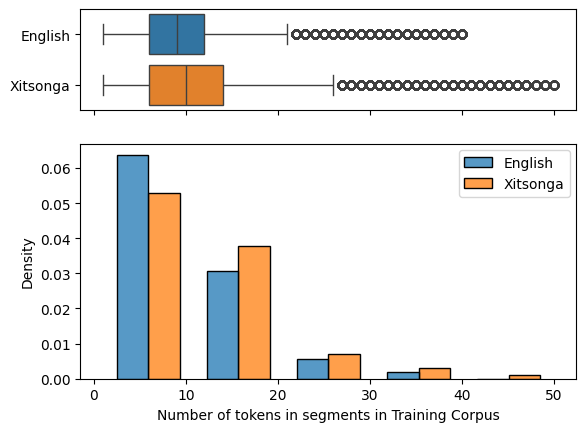

In [52]:
# visualise data!
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.3, .7)})
sns.boxplot(df_train_sent_len, orient="h", ax=ax_box)
sns.histplot(df_train_sent_len,
             binwidth=10,
             stat='density',
             multiple='dodge',
             shrink=0.7,
             legend=True,
             common_norm=False,
             ax=ax_hist)

# add labels to plots
ax_hist.set_xlabel("Number of tokens in segments in Training Corpus")
ax_hist.set_ylabel("Density")

# display plot
plt.show()

In [53]:
# dropping segment pairs in validation corpus
source_max_length = 40
target_max_length = 50

source_min_length = 1
target_min_length = 1

drop_index = []

for i in range(len(df_val_sent_len)):
  if df_val_sent_len.iloc[i,0] < source_min_length:
    drop_index.append(i)
  if df_val_sent_len.iloc[i,0] > source_max_length:
    drop_index.append(i)

  if df_val_sent_len.iloc[i,1] < target_min_length:
    drop_index.append(i)
  if df_val_sent_len.iloc[i,1] > target_max_length:
    drop_index.append(i)

drop_index = list(set(drop_index))
df_val.drop(drop_index, axis=0, inplace=True)
df_val_sent_len.drop(drop_index, axis=0, inplace=True)

In [54]:
# resetting index in dataframes after dropping segment pairs
df_val.reset_index(drop=True, inplace=True)
df_val_sent_len.reset_index(drop=True, inplace=True)

### Removing segment pairs with significant source to target ratio w.r.t length of segments in a pair

In [55]:
# add a column to dataframe: length of source segment/length of target segment
df_train_sent_len = df_train_sent_len.assign(ratio = df_train_sent_len[source_name]/df_train_sent_len[target_name])
print("Summary for Training Corpus:")
print(df_train_sent_len.describe())

df_val_sent_len = df_val_sent_len.assign(ratio = df_val_sent_len[source_name]/df_val_sent_len[target_name])
print("\nSummary for Validation Corpus:")
print(df_val_sent_len.describe())

Summary for Training Corpus:
             English       Xitsonga          ratio
count  150365.000000  150365.000000  150365.000000
mean        9.986633      11.729292       0.896472
std         6.532285       8.074759       0.278861
min         1.000000       1.000000       0.033333
25%         6.000000       6.000000       0.750000
50%         9.000000      10.000000       0.880000
75%        12.000000      14.000000       1.000000
max        40.000000      50.000000      16.000000

Summary for Validation Corpus:
            English      Xitsonga         ratio
count  43818.000000  43818.000000  43818.000000
mean       9.738943     11.464284      0.894308
std        6.756355      8.254226      0.287283
min        1.000000      1.000000      0.066667
25%        5.000000      6.000000      0.750000
50%        9.000000     10.000000      0.880476
75%       12.000000     14.000000      1.000000
max       40.000000     50.000000     10.000000


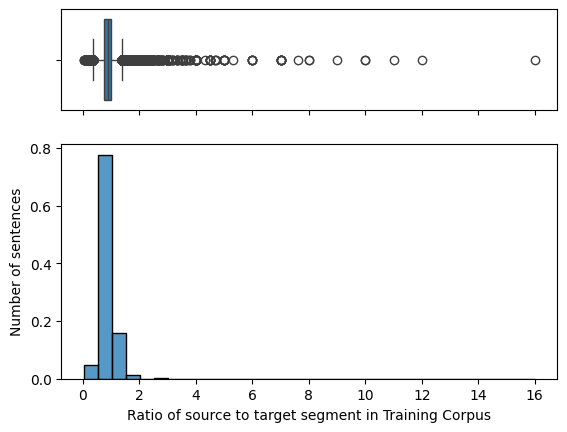

In [56]:
# visualising ratio of source to target segments pairs
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.3, .7)})
sns.boxplot(df_train_sent_len.iloc[:, 2], orient="h", ax=ax_box)
sns.histplot(df_train_sent_len.iloc[:, 2],
             binwidth=0.5,
             stat='proportion',
             ax=ax_hist)

# add labels to plots
ax_hist.set_xlabel("Ratio of source to target segment in Training Corpus")
ax_hist.set_ylabel("Number of sentences")

# display plot
plt.show()

In [57]:
# finding outlier segment pairs in the training corpus
q1 = df_train_sent_len.iloc[:, 2].quantile(0.25)
q3 = df_train_sent_len.iloc[:, 2].quantile(0.75)
iqr =  q3 - q1
lower_outliers = q1 - (1.5 * iqr)
upper_outliers = q3 + (1.5 * iqr)

print(f"The outliers upper and lower bounds of the training corpus: ({lower_outliers}, {upper_outliers})")

The outliers upper and lower bounds of the training corpus: (0.375, 1.375)


In [58]:
# finding outlier segment pairs in the validation corpus
q1 = df_val_sent_len.iloc[:, 2].quantile(0.25)
q3 = df_val_sent_len.iloc[:, 2].quantile(0.75)
iqr =  q3 - q1
lower_outliers = q1 - (1.5 * iqr)
upper_outliers = q3 + (1.5 * iqr)

print(f"The outliers upper and lower bounds of the validation corpus: ({lower_outliers}, {upper_outliers})")

The outliers upper and lower bounds of the validation corpus: (0.375, 1.375)


In [59]:
# which segment pairs in the training corpus to drop?
max_ratio = 2
min_ratio = 3/10

drop_index = []
for i in range(len(df_train_sent_len)):
  if df_train_sent_len.iloc[i,2] < min_ratio:
    drop_index.append(i)
  if df_train_sent_len.iloc[i,2] > max_ratio:
    drop_index.append(i)

drop_index = list(set(drop_index))

In [60]:
# visualising segment pairs that have been dropped
data_table.DataTable(df_train.iloc[drop_index,:], include_index=True, num_rows_per_page=20)

,English,Xitsonga
65543,Excellent poor,Swa xiyimo xa le henhla swinene leswi tsaneke
65545,10111 Emergency Centre,Va Senthara ya 10111 na Xikwadi xa maphorisa y...
65566,[ with the concurrence of the Minister of Just...,hi ku tivisa eka Gazete
49185,in accordance with section 76,milawu yo endliwa hi mayelana na mhaka yihi na...
40995,bicarbonate of soda,khukhusoda
...,...,...
81881,pair of pincers,knipitangi
73697,grandparents,h vakokwana wa yena
65509,short messaging service,sms
81910,to pass,yo pasisa hi ku landza xiyenge xa 76


In [61]:
# dropping segment pairs in training corpus
df_train.drop(drop_index, axis=0, inplace=True)
df_train_sent_len.drop(drop_index, axis=0, inplace=True)
print(f"The number of segment pairs left in the training corpus: {len(df_train)}")

# resetting index in dataframe after dropping segment pairs
df_train.reset_index(drop=True, inplace=True)
df_train_sent_len.reset_index(drop=True, inplace=True)

The number of segment pairs left in the training corpus: 149115


In [62]:
# dropping segment pairs in validation corpus
drop_index = []
for i in range(len(df_val_sent_len)):
  if df_val_sent_len.iloc[i,2] < min_ratio:
    drop_index.append(i)
  if df_val_sent_len.iloc[i,2] > max_ratio:
    drop_index.append(i)

drop_index = list(set(drop_index))

df_val.drop(drop_index, axis=0, inplace=True)
df_val_sent_len.drop(drop_index, axis=0, inplace=True)
print(f"The number of segment pairs left in the validation corpus: {len(df_val)}")

# resetting index in dataframe after dropping segment pairs
df_val.reset_index(drop=True, inplace=True)
df_val_sent_len.reset_index(drop=True, inplace=True)

The number of segment pairs left in the validation corpus: 43390


## Token Count

### Comparing source token count between training, validation and test sets:

In [63]:
# create a new dataframe: length of segment on each side of the parallel corpora
df_segment_len = pd.DataFrame({f"{source_name} in Train": df_train[source_name].str.split().apply(len),
                            f"{source_name} in Validation": df_val[source_name].str.split().apply(len),
                            f"{source_name} in Test": df_test[source_name].str.split().apply(len)})

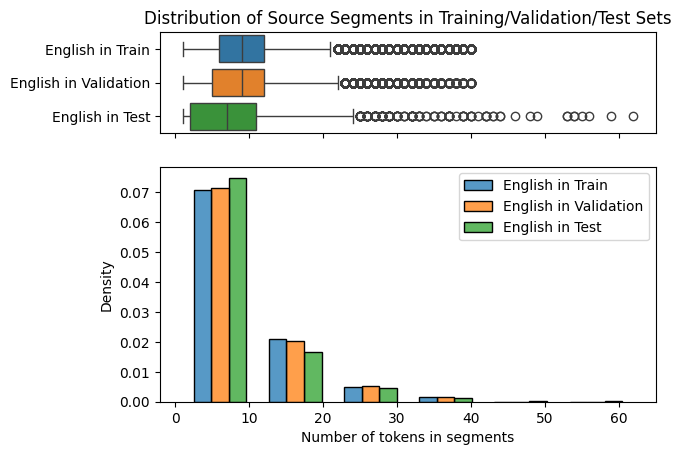

In [64]:
# visualise data!
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.3, .7)})
sns.boxplot(df_segment_len, orient="h", ax=ax_box)
sns.histplot(df_segment_len,
             binwidth=10,
             stat='density',
             multiple='dodge',
             shrink=0.7,
             legend=True,
             common_norm=False,
             ax=ax_hist)

# add labels to plots
ax_hist.set_xlabel("Number of tokens in segments")
ax_box.set_title("Distribution of Source Segments in Training/Validation/Test Sets")

# display plot
plt.show()

### Token count (incl. words, numbers and punctuation):

In [65]:
df_tokens_count = df_train.copy(deep=True)

# create new dataframes: length of words on each side of the parallel corpus
source_tokens_count = defaultdict(int)
target_tokens_count = defaultdict(int)

# counting number of tokens
for segment in df_tokens_count[source_name]:
  for word in segment.split():
    source_tokens_count[word] += 1

for segment in df_tokens_count[target_name]:
  for word in segment.split():
    target_tokens_count[word] += 1

print(f"Number of unique tokens (incl. words, numbers and punctuation) on the {source_name} side is: {len(source_tokens_count)}.")
print(f"Number of tokens (incl. words, numbers and punctuation) on the {source_name} side is: {sum(source_tokens_count.values())}.")
print()
print(f"Number of unique tokens (incl. words, numbers and punctuation) on the {target_name} side is: {len(target_tokens_count)}.")
print(f"Number of tokens (incl. words, numbers and punctuation) on the {target_name} side is: {sum(target_tokens_count.values())}.")

Number of unique tokens (incl. words, numbers and punctuation) on the English side is: 32888.
Number of tokens (incl. words, numbers and punctuation) on the English side is: 1496127.

Number of unique tokens (incl. words, numbers and punctuation) on the Xitsonga side is: 41029.
Number of tokens (incl. words, numbers and punctuation) on the Xitsonga side is: 1754422.


### Token count (incl. words and numbers):

In [66]:
# create new dataframes: length of words on each side of the parallel corpus
source_tokens_count2 = source_tokens_count.copy()
target_tokens_count2 = target_tokens_count.copy()

# counting number of tokens
for token in source_tokens_count:
  if token in punc:
    source_tokens_count2.pop(token)

for token in target_tokens_count:
  if token in punc:
    target_tokens_count2.pop(token)

print(f"Number of unique tokens (incl. words and numbers) on the {source_name} side is: {len(source_tokens_count2)}.")
print(f"Number of tokens (incl. words and numbers) on the {source_name} side is: {sum(source_tokens_count2.values())}.")
print()
print(f"Number of unique tokens (incl. words and numbers) on the {target_name} side is: {len(target_tokens_count2)}.")
print(f"Number of tokens (incl. words and numbers) on the {target_name} side is: {sum(target_tokens_count2.values())}.")

Number of unique tokens (incl. words and numbers) on the English side is: 32863.
Number of tokens (incl. words and numbers) on the English side is: 1340662.

Number of unique tokens (incl. words and numbers) on the Xitsonga side is: 41004.
Number of tokens (incl. words and numbers) on the Xitsonga side is: 1600332.


### Token count (i.e., just words):

In [67]:
# create new dataframes: length of words on each side of the parallel corpus
source_tokens_count3 = source_tokens_count2.copy()
target_tokens_count3 = target_tokens_count2.copy()

# counting number of tokens
for token in source_tokens_count2:
  if token.isdigit() == True:
    source_tokens_count3.pop(token)

for token in target_tokens_count2:
  if token.isdigit() == True:
    target_tokens_count3.pop(token)

print(f"Number of unique tokens (i.e. just words) on the {source_name} side is: {len(source_tokens_count3)}.")
print(f"Number of tokens (i.e. just words) on the {source_name} side is: {sum(source_tokens_count3.values())}.")
print()
print(f"Number of unique tokens (i.e. just words) on the {target_name} side is: {len(target_tokens_count3)}.")
print(f"Number of tokens (i.e. just words) on the {target_name} side is: {sum(target_tokens_count3.values())}.")

Number of unique tokens (i.e. just words) on the English side is: 32091.
Number of tokens (i.e. just words) on the English side is: 1323760.

Number of unique tokens (i.e. just words) on the Xitsonga side is: 40256.
Number of tokens (i.e. just words) on the Xitsonga side is: 1583684.


### Comparing length of words between source and target:

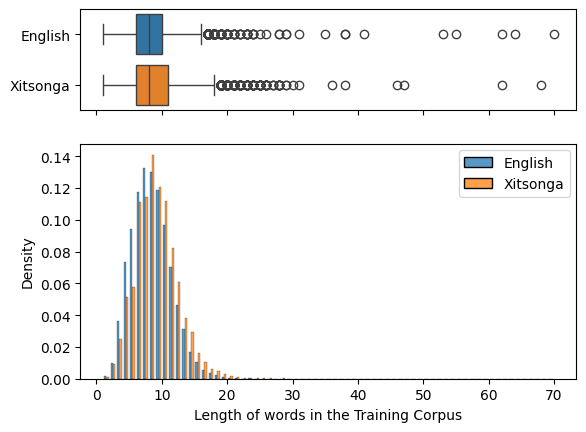

In [68]:
# create a new dataframe: length of segment on each side of the parallel corpora
source_word_len = pd.DataFrame({word: list(source_tokens_count3.keys())})
source_word_len = source_word_len.assign(source_name = source_word_len[word].str.len())
source_word_len = source_word_len.rename(columns={'source_name': source_name})
target_word_len = pd.DataFrame({word: list(target_tokens_count3.keys())})
target_word_len = target_word_len.assign(target_name = target_word_len[word].str.len())
target_word_len = target_word_len.rename(columns={'target_name': target_name})

# visualise!
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.3, .7)})
sns.boxplot([source_word_len.iloc[:, 1], target_word_len.iloc[:, 1]], orient="h", ax=ax_box)
sns.histplot([source_word_len.iloc[:, 1], target_word_len.iloc[:, 1]],
             binwidth=1,
             stat='density',
             multiple='dodge',
             shrink=0.7,
             common_norm=False,
             legend=True,
             ax=ax_hist)

# add labels to plots
ax_hist.set_xlabel("Length of words in the Training Corpus")
ax_hist.set_ylabel("Density")

# display plot
plt.show()

## Convert Datasets to Binary Files

For tokenization and model building...

In [69]:
with open(f'{main_path}/cleaned-data/train.{source_code}', 'w') as f:
  for segment in df_train[source_name]:
    f.write(segment + '\n')

with open(f'{main_path}/cleaned-data/train.{target_code}', 'w') as f:
  for segment in df_train[target_name]:
    f.write(segment + '\n')

with open(f'{main_path}/cleaned-data/val.{source_code}', 'w') as f:
  for segment in df_val[source_name]:
    f.write(segment + '\n')

with open(f'{main_path}/cleaned-data/val.{target_code}', 'w') as f:
  for segment in df_val[target_name]:
    f.write(segment + '\n')

with open(f'{main_path}/cleaned-data/test.{source_code}', 'w') as f:
  for segment in df_test[source_name]:
    f.write(segment + '\n')

with open(f'{main_path}/cleaned-data/test.{target_code}', 'w') as f:
  for segment in df_test[target_name]:
    f.write(segment + '\n')